In [1]:
import pickle
import numpy as np
import pandas as pd
from scipy import linalg, sparse
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
import matplotlib.pyplot as pp
from sklearn.decomposition import TruncatedSVD, PCA
from scipy.sparse import csr_matrix
from sklearn.preprocessing import StandardScaler

## 02 - Analyze the data to determine the *k*-value to use for SVD and PCA

Determine the *k*-value to use for the SVD and PCA dimensional reductions

### 2.1) Import Preprocessed data from step 1

Import the likes data

In [3]:
likesMAT = pickle.load(open("likesMAT.pkl","rb"))
likesMAT.shape

(9500, 536204)

Import the ages data

In [4]:
agesARR = pickle.load(open("agesARR.pkl", "rb"))
agesARR.shape

(9500, 4)

Do a train/test split

In [5]:
train_likesMAT, test_likesMAT, train_agesARR, test_agesARR = train_test_split(likesMAT, agesARR, test_size=0.05, random_state=42)

### 2.2) Compute eigenvalues

First, get a square matrix of the smallest dimension

In [6]:
sq_likesMAT_1 = np.dot(train_likesMAT, train_likesMAT.T)
sq_likesMAT_1.shape

(9025, 9025)

Convert the square matrix to a Torch tensor and move to GPU

In [7]:
tensor_sq_likesMAT = torch.Tensor(sq_likesMAT_1.todense()) \
                            .to(torch.float) \
                            .cuda()

Compute the eigenvalues on the GPU, cast to reals only (*there should be no imaginary parts*), return to the CPU, and convert to a 1D numpy array

In [8]:
tensor_sq_likesMAT_evals = torch.linalg.eig(tensor_sq_likesMAT)

sq_likesMAT_evals = tensor_sq_likesMAT_evals.eigenvalues.to(torch.float32).cpu().numpy()
print(sq_likesMAT_evals)

[6.4116262e+04 2.2268875e+04 9.1154453e+03 ... 7.0000000e+00 8.0000000e+00
 4.0000000e+00]


/tmp/ipykernel_1062/2434637442.py:3: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at ../aten/src/ATen/native/Copy.cpp:305.)
  sq_likesMAT_evals = tensor_sq_likesMAT_evals.eigenvalues.to(torch.float32).cpu().numpy()


Clean-up GPU VRAM to preserve available space to work

In [9]:
del tensor_sq_likesMAT_evals
del tensor_sq_likesMAT

torch.cuda.empty_cache()

Print the last hundred of so eigenvalues

In [10]:
print(np.sort(sq_likesMAT_evals)[8900:])

[ 1400.53    1404.5615  1406.653   1418.6724  1424.9868  1429.432
  1435.7968  1442.3325  1446.1686  1452.7064  1465.6051  1468.512
  1469.8342  1476.0448  1484.3668  1485.9348  1494.8766  1497.2162
  1503.8088  1511.5101  1515.6145  1524.5825  1534.0132  1544.6715
  1547.1128  1557.6613  1563.7852  1572.2664  1580.386   1584.229
  1588.0059  1601.7754  1613.5876  1616.9652  1628.135   1628.884
  1639.8164  1647.7877  1668.0535  1675.874   1683.4819  1690.4858
  1700.4657  1706.6239  1716.591   1717.2465  1728.7982  1742.918
  1744.665   1757.3053  1760.6826  1761.6453  1769.3381  1780.153
  1783.9578  1793.5984  1814.6724  1828.3401  1837.3528  1851.0038
  1868.3198  1875.0363  1881.5725  1896.0278  1905.6833  1911.5977
  1913.7684  1946.7308  1954.7394  1987.2482  1993.2926  2015.8531
  2020.4531  2037.6426  2042.454   2058.4463  2072.9656  2101.6292
  2135.2285  2171.2825  2181.7717  2189.6897  2210.1108  2236.9036
  2249.4136  2284.7175  2299.6833  2329.0076  2356.223   2372.6323
 

Plot the eigenvalues in order of magnitude

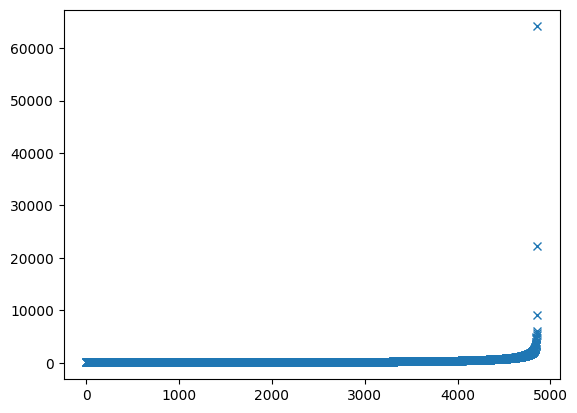

In [11]:
ind_to_start = 4000 #8050
pp.plot(np.asarray(range(np.unique(sq_likesMAT_evals)[ind_to_start:].shape[0])), np.sort(np.unique(sq_likesMAT_evals))[ind_to_start:], 'x')
pp.show()

Calculate the deltas between eigenvalues and print the last hundred or so

In [12]:
sq_likesMAT_evals_deltas = []
for i in range(1, sq_likesMAT_evals.shape[0]):
    sq_likesMAT_evals_deltas.append(np.sort(sq_likesMAT_evals)[i] - np.sort(sq_likesMAT_evals)[i-1])

sq_likesMAT_evals_deltas = np.asarray(sq_likesMAT_evals_deltas)
sq_likesMAT_evals_deltas.shape

(9024,)

In [13]:
np.unique(sq_likesMAT_evals_deltas).shape

(7854,)

Print out the top values

In [14]:
print(np.sort(sq_likesMAT_evals_deltas)[8900:])
np.sort(sq_likesMAT_evals_deltas)[8900:].shape

[5.0063477e+00 5.0427246e+00 5.0948486e+00 5.1510010e+00 5.2489624e+00
 5.3062744e+00 5.3186035e+00 5.3583984e+00 5.3673096e+00 5.4064941e+00
 5.5139160e+00 5.5185547e+00 5.6945801e+00 5.9143066e+00 6.0444336e+00
 6.1239014e+00 6.1582031e+00 6.2105713e+00 6.3144531e+00 6.3647461e+00
 6.5357666e+00 6.5362549e+00 6.5378418e+00 6.5926514e+00 6.7164307e+00
 6.8741455e+00 6.9803467e+00 6.9866943e+00 7.0039062e+00 7.1979980e+00
 7.4671631e+00 7.4783936e+00 7.6079102e+00 7.6928711e+00 7.7012939e+00
 7.7105713e+00 7.8205566e+00 7.9179688e+00 7.9713135e+00 8.0085449e+00
 8.1196289e+00 8.3220215e+00 8.4812012e+00 8.6141357e+00 8.7197266e+00
 8.8808594e+00 8.9417725e+00 8.9680176e+00 9.0126953e+00 9.4306641e+00
 9.6406250e+00 9.6555176e+00 9.6682129e+00 9.9670410e+00 9.9798584e+00
 1.0116943e+01 1.0489258e+01 1.0548462e+01 1.0658325e+01 1.0814819e+01
 1.0932373e+01 1.1169800e+01 1.1551758e+01 1.1812256e+01 1.2019409e+01
 1.2510010e+01 1.2537598e+01 1.2640259e+01 1.2898682e+01 1.3651001e+01
 1.366

(124,)

Plot the eigenvalue deltas in order of magnitude

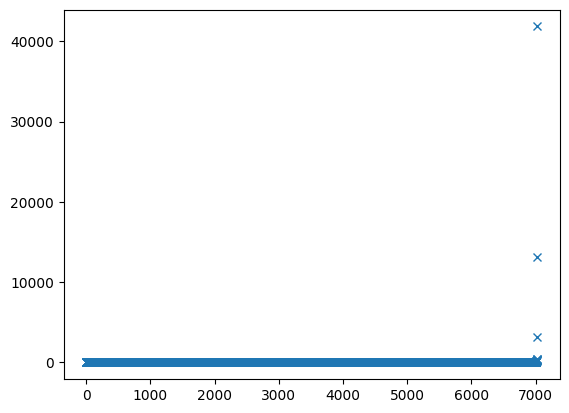

In [15]:
ind_to_start = 2000
pp.plot(np.asarray(range(sq_likesMAT_evals_deltas[ind_to_start:].shape[0])), np.sort(sq_likesMAT_evals_deltas)[ind_to_start:], 'x')
pp.show()

### 2.3) Compute PCA stuff

PCA requires scaling our inputs, so we have

In [16]:
scaler = StandardScaler(with_mean=False)
train_likesMAT_std = scaler.fit_transform(train_likesMAT)
test_likesMAT_std = scaler.transform(test_likesMAT)

Apply PCA

In [ ]:
pca = PCA(n_components=4002)
# pca = PCA()
train_likesMAT_pca = pca.fit_transform(train_likesMAT_std)

# Calculate the cumulative explained variance
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Determine the number of components to keep for 85% variance explained
n_components = np.argmax(cumulative_variance_ratio >= 0.85) + 1

In [ ]:
print(n_components)

In [ ]:
print(cumulative_variance_ratio)

In [ ]:
len(cumulative_variance_ratio)

In [ ]:
print(max(cumulative_variance_ratio))
print(cumulative_variance_ratio[3750:])